In [ ]:
# $ python -m venv carpark
# $ Set-ExecutionPolicy RemoteSigned
# $ .\carpark\Scripts\activate
# $ Set-ExecutionPolicy Restricted
# $ pip freeze > requirements.txt

In [1]:
import numpy as np
import os
import pandas as pd
import xml.etree.ElementTree as ET
import glob
import csv

from tflite_model_maker.config import QuantizationConfig
from tflite_model_maker.config import ExportFormat
from tflite_model_maker import model_spec
from tflite_model_maker import object_detector

import tensorflow as tf
assert tf.__version__.startswith('2')

tf.get_logger().setLevel('ERROR')
from absl import logging
logging.set_verbosity(logging.ERROR)

In [ ]:
#https://www.tensorflow.org/lite/tutorials/model_maker_object_detection



In [ ]:
# Model architecture	Size(MB)*	Latency(ms)**	Average Precision***
# EfficientDet-Lite0	4.4	        37	            25.69%
# EfficientDet-Lite1	5.8	        49	            30.55%
# EfficientDet-Lite2	7.2	        69	            33.97%
# EfficientDet-Lite3	11.4	    116	            37.70%
# EfficientDet-Lite4	19.9	    260	            41.96%

spec = model_spec.get('efficientdet_lite2')

In [2]:
object_detector.DataLoader.__dict__

mappingproxy({'__module__': 'tensorflow_examples.lite.model_maker.core.data_util.object_detector_dataloader',
              '__doc__': 'DataLoader for object detector.',
              '__init__': <function tensorflow_examples.lite.model_maker.core.data_util.object_detector_dataloader.DataLoader.__init__(self, tfrecord_file_patten, size, label_map, annotations_json_file=None)>,
              'from_pascal_voc': <classmethod at 0x1a465b4b310>,
              'from_csv': <classmethod at 0x1a465b4ba60>,
              'from_cache': <classmethod at 0x1a465b4bb50>,
              'gen_dataset': <function tensorflow_examples.lite.model_maker.core.data_util.object_detector_dataloader.DataLoader.gen_dataset(self, model_spec, batch_size=None, is_training=False, use_fake_data=False)>,
              'split': <function tensorflow_examples.lite.model_maker.core.data_util.object_detector_dataloader.DataLoader.split(self, fraction)>})

In [2]:
def xml_to_csv(xml_file):
    tree = ET.parse(xml_file)
    root = tree.getroot()

    img_obj = root.findall('images')[0]

    xml_list = []
    # nested XML structure from the downloaded dataset
    for child in img_obj:
        img_path = os.path.join('./dlib_front_and_rear_vehicles_v1', child.attrib['file'])
        for box in child:
            top = box.attrib['top']
            left = box.attrib['left']
            width = box.attrib['width']
            height = box.attrib['height']
            ignore_field = box.attrib['ignore'] if 'ignore' in box.attrib else '0'
            gt_label = box.find('label').text
            
            if int(ignore_field):
                next
            
            else:
                value = (img_path, gt_label, top, left, width, height)
                xml_list.append(value)

    column_name = ['filename', 'label', 'top', 'left', 'width', 'height']
    xml_df = pd.DataFrame(xml_list, columns=column_name)

    return xml_df


In [3]:
xml_file_train = ".\\dlib_front_and_rear_vehicles_v1\\training.xml"
xml_file_test = ".\\dlib_front_and_rear_vehicles_v1\\testing.xml"

csv_df = xml_to_csv(xml_file_train)
csv_df.to_csv('./train.csv', index = False)

csv_df = xml_to_csv(xml_file_test)
csv_df.to_csv('./test.csv', index = False)

In [4]:
train_data = pd.read_csv('./train.csv')
train_data.head()

,filename,label,top,left,width,height
0,./dlib_front_and_rear_vehicles_v1\la_hill_st/l...,front,1406,668,203,134
1,./dlib_front_and_rear_vehicles_v1\la_hill_st/l...,front,1389,812,174,127
2,./dlib_front_and_rear_vehicles_v1\la_hill_st/l...,front,1389,968,210,145
3,./dlib_front_and_rear_vehicles_v1\la_hill_st/l...,front,1375,1063,160,141
4,./dlib_front_and_rear_vehicles_v1\la_hill_st/l...,rear,1309,1231,350,243


In [26]:
test_data = pd.read_csv('./test.csv')
test_data.head()

,filename,label,top,left,width,height
0,./dlib_front_and_rear_vehicles_v1\normal_rgb_i...,rear,271,636,264,183
1,./dlib_front_and_rear_vehicles_v1\normal_rgb_i...,rear,369,550,117,90
2,./dlib_front_and_rear_vehicles_v1\normal_rgb_i...,rear,360,387,76,74
3,./dlib_front_and_rear_vehicles_v1\normal_rgb_i...,rear,337,456,56,77
4,./dlib_front_and_rear_vehicles_v1\normal_rgb_i...,rear,349,554,65,66


### Check plot

rear


<function matplotlib.pyplot.show(close=None, block=None)>

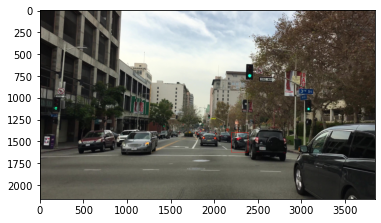

In [25]:
import cv2
import os
import matplotlib.pyplot as plt

idx = 709

file_name = train_data.filename[idx]

img_BGR = cv2.imread(file_name)
img_RGB = cv2.cvtColor(img_BGR, cv2.COLOR_BGR2RGB)

start_point = (train_data.left[idx], train_data.top[idx])
end_point = (start_point[0] + train_data.height[idx], start_point[1] + train_data.width[idx])
print(train_data.label[idx])
image = cv2.rectangle(img_RGB, start_point, end_point, (255, 0, 0), 2)
plt.imshow(img_RGB)
plt.show

In [ ]:
model = object_detector.create(train_data, model_spec=spec, batch_size=8, train_whole_model=True, validation_data=validation_data)